# Press ```Run All``` after changing the ```is_demo``` & ```is_training``` variables below

In [ ]:
is_demo = True  # Set to True for demonstration, False for actual data collection and training
is_training = False  # Set to True for training, False for data collection and demonstration

In [322]:
# Libraries
import numpy as np
import pandas as pd
import serial
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set seed for reproducibility
def seed_all(seed=0):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [ ]:
# Format: Object-Distance-Height
class_names = ["Coin-10cm-10cm", "Coin-10cm-30cm", "Coin-30cm-10cm", "Coin-30cm-30cm",
               "Eraser-10cm-10cm", "Eraser-10cm-30cm", "Eraser-30cm-10cm", "Eraser-30cm-30cm",
               "Eraser-150cm-10cm"]

## Modify ```# Parameters```

In [ ]:
# Parameters
adc_threshold = 1000  # ADC threshold to start data collection
num_items_to_collect = 200  # Number of ADC values to collect
class_label = class_names.index("Coin-10cm-10cm")  # Class label for the current data collection - ignored if is_demo is True
filepath = "data/data_train.csv"  # Name of the CSV file to save the data - ignored if is_demo is True

# Data Collection

In [ ]:
# Initialize serial communication
ser = serial.Serial(port="COM8", baudrate=230400, timeout=1)  # Configure the serial port
ser.flush()  # Flush the serial buffer to clear any existing data


# Function to read ADC value from the serial port
def read_adc_value():
    """
    Reads a single ADC value from the serial port.
    Returns:
        int: The ADC value if successfully read, otherwise None.
    """
    try:
        if ser.in_waiting > 0:  # Check if data is available in the serial buffer
            line = ser.readline().decode('utf-8').strip()  # Read and decode the line
            return int(line)  # Convert the line to an integer
    except ValueError:
        # Ignore invalid data that cannot be converted to an integer
        pass
    return None


# Function to save collected data to a CSV file
def save_to_csv(data, label, filepath):
    """
    Saves the collected data to a CSV file.
    Args:
        data (list): The list of collected ADC values.
        label (int): The class label for the data.
        filepath (str): The name of the CSV file to save the data.
    """
    # Add the new row to the dataframe
    df.loc[len(df)] = [label] + data
    # Save the dataframe to a CSV file
    df.to_csv(filepath, index=False)


# Read existing CSV file if it exists, otherwise create a new dataframe
if not is_demo:
    try:
        df = pd.read_csv(filepath)  # Try to read the existing CSV file
    except FileNotFoundError:
        # Create a new dataframe with appropriate columns if the file doesn't exist
        df = pd.DataFrame(columns=["label"] + ["data" + str(i + 1) for i in range(num_items_to_collect)])

# Data collection process
data = []  # List to store collected ADC values

try:
    print("Data collection started...")
    activated = False  # Flag to indicate if the threshold has been crossed

    # Collect data until the required number of items is reached
    while len(data) < num_items_to_collect:
        adc_value = read_adc_value()  # Read an ADC value
        if adc_value is not None:
            if not activated and adc_value > adc_threshold:
                # Start collecting data only after the threshold is crossed
                activated = True
                print("Threshold crossed. Collecting data...")
            if activated:
                # Append the ADC value to the data list
                data.append(adc_value)

    print("Data collection completed.")
except KeyboardInterrupt:
    # Handle manual interruption (Ctrl+C)
    print("Data collection interrupted.")
except Exception as e:
    # Handle any other exceptions
    print(f"An error occurred: {e}")

# Save the collected data to a CSV file
if not is_demo:
    if data:
        save_to_csv(data, class_label, filepath)  # Save the data with the class label
        print("Data saved to CSV.")
    else:
        print("No data collected.")
else:
    # For demonstration, just print the collected data
    print("Collected data (for demo)")

# Close the serial port
ser.close()

## Plot the latest collected data

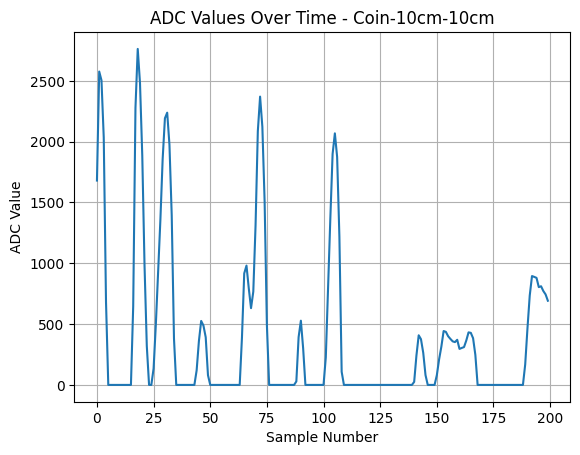

In [327]:
plt.plot(range(len(data)), data)  # Plot the ADC values
plt.xlabel("Sample Number")  # Label for the x-axis
plt.ylabel("ADC Value")  # Label for the y-axis
plt.title(f"ADC Values Over Time - {class_names[class_label]}")  # Title of the plot
plt.grid()  # Show grid lines on the plot
plt.show()  # Display the plot

# Fourier Transform ([Credit](https://www.youtube.com/watch?v=s2K1JfNR7Sc))

## Compute the Fast Fourier Transform (FFT) and plot the Power Spectral Density (PSD) for the latest collected data

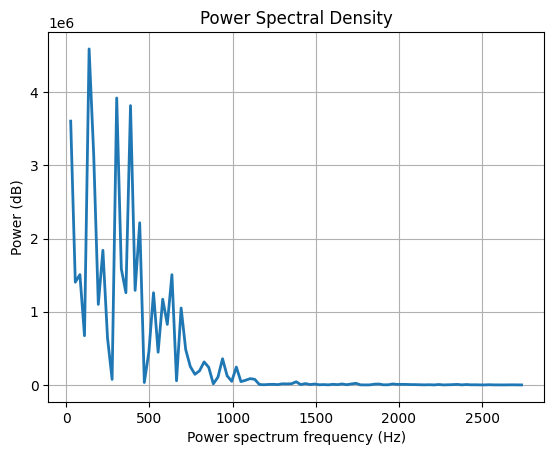

In [328]:
fs = 5530  # Sampling frequency in Hz

n = len(data)  # Number of samples

# Compute the FFT and Power Spectral Density (PSD)
fhat = np.fft.fft(data, n)
PSD = fhat * np.conj(fhat) / n
freq = (1 / (n * (1 / fs))) * np.arange(n)  # Frequency bins
L = np.arange(1, np.floor(n / 2), dtype='int')  # Positive frequencies

# Plot the Power Spectral Density
plt.plot(freq[L], PSD[L].real, linewidth=2)
plt.xlabel('Power spectrum frequency (Hz)')
plt.ylabel('Power (dB)')
plt.title('Power Spectral Density')
plt.grid()
plt.show()

## Fourier transform entire dataset for model training

In [329]:
def compute_psd(data):
    """
    Computes the Power Spectral Density (PSD) of the input signal.
    Args:
        data (array-like): Input time-domain signal.
    Returns:
        array: PSD of the input signal.
    """
    data = data - np.mean(data)  # Remove DC offset
    n = len(data)
    fhat = np.fft.fft(data, n)
    PSD = (fhat * np.conj(fhat)) / n
    return PSD[:n // 2].real  # Return only the positive frequencies

if not is_demo:
    df = pd.read_csv(filepath)  # Read the existing CSV file

    # Create a new DataFrame to store PSD-transformed data
    psd_length = len(df.columns) - 1  # Same number of samples per row (excluding label)
    df_psd = pd.DataFrame(columns=["label"] + [f"psd{i+1}" for i in range(psd_length // 2)])

    for i in range(len(df)):
        label = int(df.iloc[i, 0])  # Extract and ensure label is int
        data = df.iloc[i, 1:].values.astype(float)  # Extract signal values
        psd = compute_psd(data)  # Compute PSD
        df_psd.loc[i] = [label] + list(psd)  # Assign to new DataFrame

    # Convert the label column to integers
    df_psd["label"] = df_psd["label"].astype(int)

    # Save the PSD-transformed data to a new CSV file
    filepath_psd = filepath.replace("data_", "data_psd_")
    df_psd.to_csv(filepath_psd, index=False)


# Train Classification Model

## Dataset class

In [330]:
class PiezoDataset(Dataset):
    def __init__(self, dataframe, mean, std):
        self.X = dataframe.drop(columns=['label']).values.astype(np.float32)

        # Normalize using train stats
        epsilon = 1e-8  # prevent divide-by-zero
        self.X = (self.X - mean) / (std + epsilon)
        
        self.y = dataframe['label'].values.astype(np.int64)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.long)
        return x, y

## Create Dataset instance from the defined Class and then the DataLoaders

In [331]:
# Load CSVs
df_train = pd.read_csv("data/data_psd_train.csv")
df_val = pd.read_csv("data/data_psd_val.csv")
df_test = pd.read_csv("data/data_psd_test.csv")

# Drop the 'label' column to isolate the input features
X_train = df_train.drop(columns=['label']).values

# Compute mean and std from the training features
means = np.mean(X_train, axis=0)
devs = np.std(X_train, axis=0)

# Create datasets
train_dataset = PiezoDataset(df_train, means, devs)
val_dataset = PiezoDataset(df_val, means, devs)
test_dataset = PiezoDataset(df_test, means, devs)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=5, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)

# Print dataset shapes
print(f"Train dataset shape: {train_dataset.X.shape}")
print(f"Validation dataset shape: {val_dataset.X.shape}")
print(f"Test dataset shape: {test_dataset.X.shape}")

Train dataset shape: (135, 100)
Validation dataset shape: (45, 100)
Test dataset shape: (45, 100)


## Design the NN

In [332]:
class PiezoNN(nn.Module):
    def __init__(self, input_size, num_classes, device='cpu'):
        super(PiezoNN, self).__init__()
        self.device = device
        self.fc1 = nn.Linear(input_size, 512)  # Increase units in the first layer
        self.fc2 = nn.Linear(512, 256)         # Decrease units in the second layer
        self.fc3 = nn.Linear(256, num_classes) # Output layer
        self.bn1 = nn.BatchNorm1d(512)         # Batch normalization after first layer
        self.bn2 = nn.BatchNorm1d(256)         # Batch normalization after second layer
        self.dropout = nn.Dropout()         # Dropout to prevent overfitting

    def forward(self, x):
        x = F.relu(self.fc1(x))  # ReLU activation after the first layer
        x = self.bn1(x)          # Batch Normalization
        x = self.dropout(x)      # Apply dropout for regularization
        x = F.relu(self.fc2(x))  # ReLU activation after the second layer
        x = self.bn2(x)          # Batch Normalization
        x = self.dropout(x)      # Apply dropout for regularization
        x = self.fc3(x)          # Output layer
        return x                 # Return without softmax (F.cross_entropy will do it automatically)

    def train_model(self, epochs, optimizer, scheduler, train_loader, val_loader, verbose=True):
        self.loss_train_log = []
        self.loss_val_log = []
        self.best_loss = np.inf

        # Move model to device
        self.to(device=self.device)

        for epoch in range(epochs):
            self.train()
            for x, y in train_loader:
                x = x.to(device=self.device)
                y = y.to(device=self.device)

                optimizer.zero_grad()
                yhat = self.forward(x)
                loss = F.cross_entropy(yhat, y)
                loss.backward()
                optimizer.step()

            # Step the scheduler
            scheduler.step()

            # Calculate loss for training and validation sets
            loss_train = self.evaluate(train_loader)
            self.loss_train_log.append(loss_train)

            loss_val = self.evaluate(val_loader)
            self.loss_val_log.append(loss_val)

            if verbose:
                print(f'Epoch {epoch+1}/{epochs}: Train Loss = {loss_train:.4f}, Val Loss = {loss_val:.4f}')

            if loss_val < self.best_loss:
                self.best_loss = loss_val
                best_epoch = epoch + 1
                torch.save(self.state_dict(), "best_model.pt") # Save the best model
                
        print(f'Best model saved at epoch {best_epoch} with loss {self.best_loss:.4f}.')

    def evaluate(self, loader):
        self.eval()
        loss = 0
        with torch.no_grad():
            for x, y in loader:
                x = x.to(device=self.device)
                y = y.to(device=self.device)
                yhat = self.forward(x)
                loss += F.cross_entropy(yhat, y, reduction='sum')
        
        loss /= len(loader.dataset)
        return loss.cpu()

    def predict(self, loader):
        self.eval()
        x_all, y_all, logit = [], [], []
        with torch.no_grad():
            for x, y in loader:
                x_all += [x]
                y_all += [y]
                x = x.to(device=self.device)  # Move data to the same device as model
                y = y.to(device=self.device)  # Move labels to the same device as model
                yhat = self.forward(x)
                logit.append(yhat.cpu())  # Move logits back to CPU for easier manipulation
                
            x_all, y_all, logit = torch.cat(x_all, dim=0), torch.cat(y_all, dim=0), torch.cat(logit, dim=0)
            return x_all, y_all, logit

## Train the network

In [ ]:
if is_training:
    # Model training
    input_size = len(train_dataset[0][0])  # Number of features in your dataset
    num_classes = len(class_names)  # Number of unique labels
    model = PiezoNN(input_size=input_size, num_classes=num_classes, device=device)

    # Define possible hyperparameter values to test
    lr_values = [0.001, 0.01, 0.1]
    weight_decay_values = [0.0001, 0.001, 0.01]
    step_size_values = [3, 5, 10]
    gamma_values = [0.7, 0.8, 0.9]

    # Initialize variables to store the best result
    best_val_loss = float('inf')
    best_hyperparameters = None
    best_model_state = None
    best_model_losses = {
        "loss_train_log": [],
        "loss_val_log": []
    }

    # Hyperparameter sweep
    for lr in lr_values:
        for weight_decay in weight_decay_values:
            for step_size in step_size_values:
                for gamma in gamma_values:
                    print(f"Testing with lr={lr}, weight_decay={weight_decay}, step_size={step_size}, gamma={gamma}")

                    # Re-initialize the model to start fresh for each hyperparameter combination
                    model = PiezoNN(input_size=input_size, num_classes=num_classes, device=device)
                    
                    # Set up the optimizer and learning rate scheduler
                    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
                    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
                    
                    # Train the model
                    model.train_model(epochs=100, optimizer=optimizer, scheduler=scheduler, train_loader=train_loader, val_loader=val_loader)
                    
                    # Evaluate on the validation set
                    val_loss = model.evaluate(val_loader)
                    
                    # Check if this is the best validation loss
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        best_hyperparameters = {'lr': lr, 'weight_decay': weight_decay, 'step_size': step_size, 'gamma': gamma}
                        best_model_state = model.state_dict()  # Save the model state for best performance
                        best_model_losses = {
                            "loss_train_log": model.loss_train_log,
                            "loss_val_log": model.loss_val_log
                        }

    # Save the best model
    torch.save(best_model_state, 'best_model.pt')

    # Print the best hyperparameters
    print(f"Best hyperparameters: {best_hyperparameters}")

## Inspecting the training and validation loss for the best model

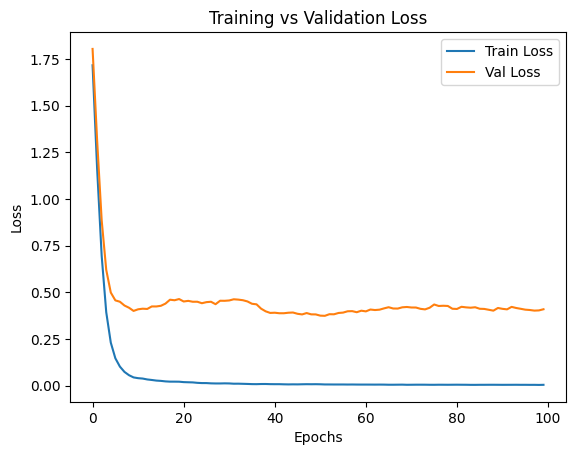

In [337]:
if "best_model_losses" in locals():
    # Plotting training vs val loss
    plt.plot(best_model_losses["loss_train_log"], label='Train Loss')
    plt.plot(best_model_losses["loss_val_log"], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.show()

# Evaluate Classification Model (using test dataset)

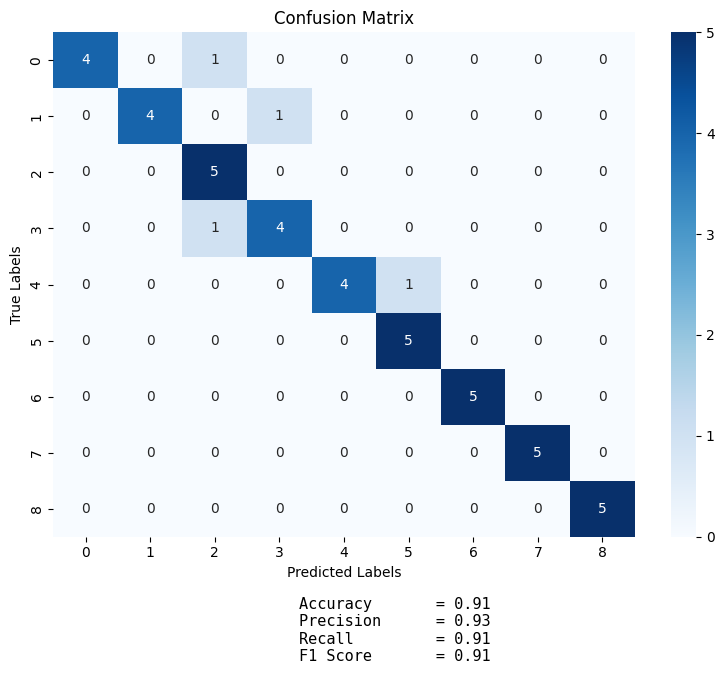

In [335]:
# Load the best model
best_params = torch.load('best_model.pt')
model_best = PiezoNN(input_size=input_size, num_classes=num_classes, device=device)
model_best.load_state_dict(best_params)
model_best.to(device)

# Evaluate of test data
x_all, y_all, logit = model_best.predict(test_loader)
predictions = F.softmax(logit, dim=1).argmax(dim=1)

# Calculate confusion matrix and other metrics
y_true = y_all.cpu().numpy()  # True labels
y_pred = predictions.cpu().numpy()  # Predicted labels
cMat = metrics.confusion_matrix(y_true, y_pred)

accuracy = metrics.accuracy_score(y_true, y_pred)
precision = metrics.precision_score(y_true, y_pred, average='macro')  # Macro for multi-class
recall = metrics.recall_score(y_true, y_pred, average='macro')  # Macro for multi-class
f1 = metrics.f1_score(y_true, y_pred, average='macro')  # Macro for multi-class

# Plot using Seaborn with index labels
plt.figure(figsize=(8, 6))
sns.heatmap(cMat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()

metrics_text = f"""
Accuracy       = {accuracy:.2f}
Precision      = {precision:.2f}
Recall         = {recall:.2f}
F1 Score       = {f1:.2f}
"""

# Create a text box
plt.gcf().text(0.5, -0.11, metrics_text.strip(), ha='center', fontsize=11, family='monospace')

plt.tight_layout()
plt.show()

# Demo Run

In [ ]:
if is_demo:    
    # Create a DataFrame for the demo data with a dummy label (0)
    demo_df_psd = pd.DataFrame(columns=["label"] + [f"psd{i+1}" for i in range(psd_length // 2)])
    demo_df_psd.loc[0] = [0] + list(compute_psd(data))  # Assign to new DataFrame

    # Create a PiezoDataset instance for the demo data
    demo_data = PiezoDataset(demo_df_psd, means, devs)
    demo_loader = DataLoader(demo_data, batch_size=1, shuffle=False)  # Create a DataLoader for the demo data

    # Predict the class for the demo data
    x, y, logit = model_best.predict(demo_loader)
    ypred_demo = F.softmax(logit, dim=1).argmax(dim=1)  # Get the predicted class for the demo data
    print(f"Predicted class: {class_names[ypred_demo]}")

Predicted class: Eraser-30cm-10cm
